# Time series analysis
1. Time series analysis comprises methods for analyzing time series data in order to extract meaningful statistics and other characteristics of the data.
2. Time series forecasting is the use of a model to predict future values based on previously observed values.
3. Time series analysis can be applied to real-valued, continuous data, discrete numeric data, or discrete symbolic data

In [1]:
# Importing Libraries for time series forecasting

import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from math import sqrt

import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns

from random import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

In [2]:
#importing data set of airlines passangers and replacing the header
df = pd.read_csv('international-airline-passengers.csv', header=None)

In [3]:
# replacing the headers
df.columns = ['year','passengers']

In [4]:
#eliminating the first row
df = df.iloc[1:-1]
print('Time period start: {}\nTime period end: {}'.format(df.year.min(),df.year.max()))

Time period start: 1949-01
Time period end: 1960-12


In [5]:
#data structures
df.head(4)

,year,passengers
1,1949-01,112
2,1949-02,118
3,1949-03,132
4,1949-04,129


In [6]:
#checking the range of data
df.shape

(144, 2)

# Data Preprocessing and Visualization

In [7]:
#Converting to datetime format:
df['year'] = pd.to_datetime(df['year'], format='%Y-%m')

In [8]:
df.head(4)

,year,passengers
1,1949-01-01,112
2,1949-02-01,118
3,1949-03-01,132
4,1949-04-01,129


### Setting index as the datetime column for easier manipulations:

In [9]:
y = df.set_index('year')

In [10]:
y.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01', '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01', '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01', '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01', '1960-11-01', '1960-12-01'], dtype='datetime64[ns]', name='year', length=144, freq=None)

In [11]:
y.isnull().sum()
y=y.astype(float)

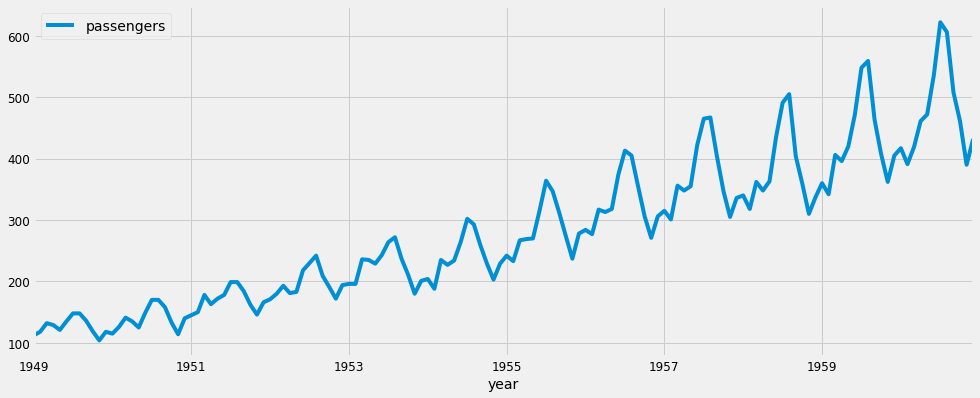

In [12]:
# Create a time series plot.
y.plot(figsize=(15, 6))
plt.show()

1. This shows that there is a growing number of passengers with an increasing number of years
2. There is also an increasing cyclical trend that we notice

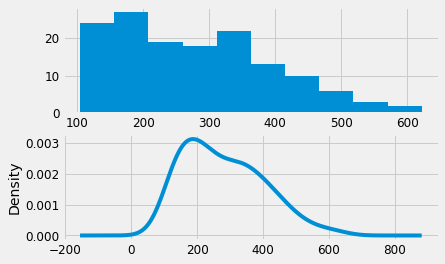

In [13]:
from pandas import Series
from matplotlib import pyplot
pyplot.figure(1)
pyplot.subplot(211)
y.passengers.hist()
pyplot.subplot(212)
y.passengers.plot(kind='kde')
pyplot.show()

The data is left Skewed and not perfectly normal

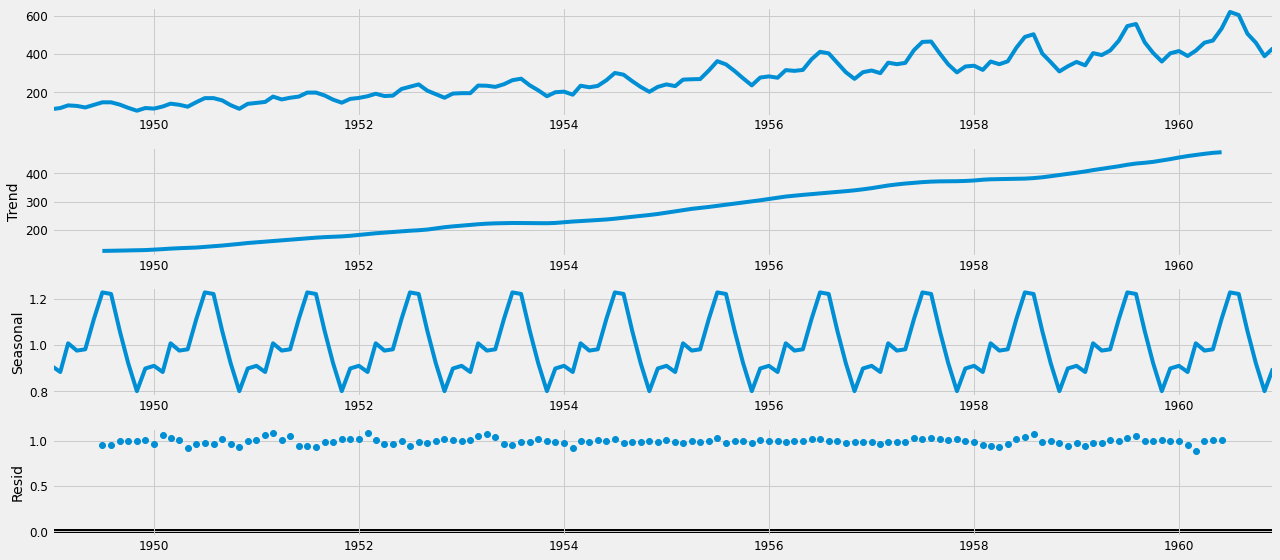

In [14]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative')
fig = decomposition.plot()
plt.show()

There is a clear increasing trend and a constant seasonality. 
If a Time Series has a particular behaviour over time, there is a very high probability that it will follow the same in the future.

### Stationarity
- A Time Series is said to be stationary if its statistical properties such as mean, variance remain constant over time.
- Most of the Time Series models work on the assumption that the TS is stationary. Major reason for this is that there are many ways in which a series can be non-stationary, but only one way for stationarity.
- Intuitively, we can say that if a Time Series has a particular behaviour over time, there is a very high probability that it will follow the same in the future.
- Also, the theories related to stationary series are more mature and easier to implement as compared to non-stationary series.

### We can check stationarity using the following:
- ACF and PACF plots: If the time series is stationary, the ACF/PACF plots will show a quick drop-off in correlation after a small amount of lag between points.
- Plotting Rolling Statistics: We can plot the moving average or moving variance and see if it varies with time. Moving average/variance is for any instant ‘t’, the average/variance of the last year, i.e. last 12 months.
- Augmented Dickey-Fuller Test: This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary. 

### ACF and PACF plots
Let's review the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots
1. If the time series is stationary, the ACF/PACF plots will show a quick drop-off in correlation after a small amount of lag between points.
2. This data is non-stationary as a high number of previous observations are correlated with future values.
3. Confidence intervals are drawn as a cone.
4. By default, this is set to a 95% confidence interval, suggesting that correlation values outside of this code are very likely a correlation and not a statistical fluke.
5. The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags.

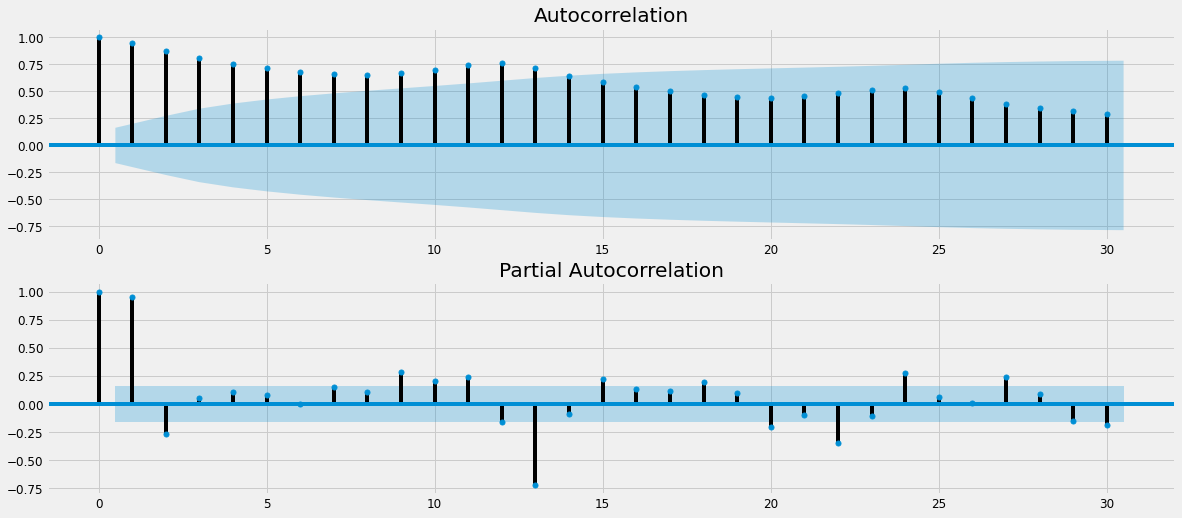

In [15]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

pyplot.figure()
pyplot.subplot(211)
plot_acf(y.passengers, ax=pyplot.gca(), lags = 30)
pyplot.subplot(212)
plot_pacf(y.passengers, ax=pyplot.gca(), lags = 30)
pyplot.show()

### Plotting Rolling Statistics
1. We observe that the rolling mean and Standard deviation are not constant with respect to time (increasing trend)
2. The time series is hence not stationary

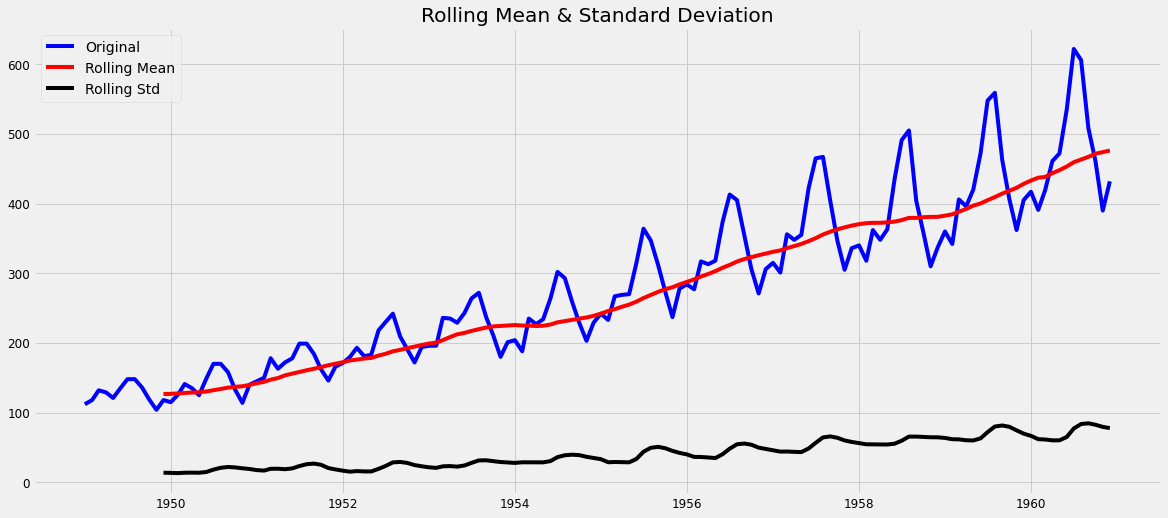

In [16]:
#Determing rolling statistics
rolmean = y.passengers.rolling(window=12).mean()
rolstd = y.passengers.rolling(window=12).std()

#Plot rolling statistics:
orig = plt.plot(y, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

### Augmented Dickey-Fuller Test
1. The intuition behind the test is that if the series is integrated then the lagged level of the series y(t-1) will provide no relevant information in predicting the change in y(t).
2. Null hypothesis: The time series is not stationary
3. Rejecting the null hypothesis (i.e. a very low p-value) will indicate staionarity

In [17]:
from statsmodels.tsa.stattools import adfuller

In [18]:
#Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(y.passengers, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [19]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()


    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

## Making Time Series Stationary
There are 2 major reasons behind non-stationaruty of a TS:

1. Trend – varying mean over time. For eg, in this case we saw that on average, the number of passengers was growing over time.
2. Seasonality – variations at specific time-frames. eg people might have a tendency to buy cars in a particular month because of pay increment or festivals.

### Transformations
We can apply transformation which penalize higher values more than smaller values. These can be taking a log, square root, cube root, etc. Lets take a log transform here for simplicity:


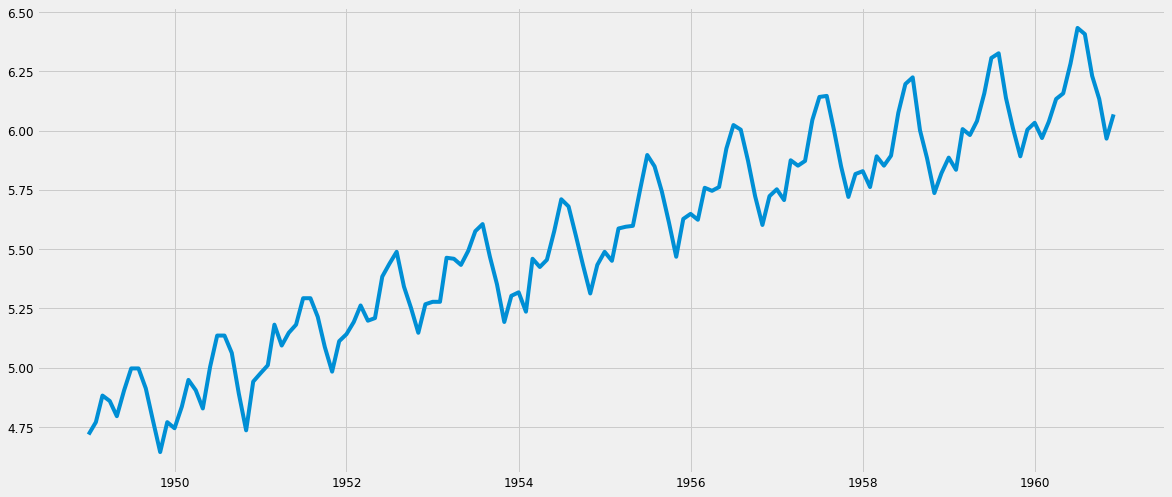

In [20]:
#log scale transformation
ts_log = np.log(y)
plt.plot(ts_log)

Other possible transformations:
* Exponential tranformation
* Box Cox transformation
* Square root transformation

### Techniques to remove Trend - Smoothing
* Smoothing is taking rolling averages over windows of time

### Moving Average
* We take average of ‘k’ consecutive values depending on the frequency of time series.
* Here we can take the average over the past 1 year, i.e. last 12 values.
* A drawback in this particular approach is that the time-period has to be strictly defined.

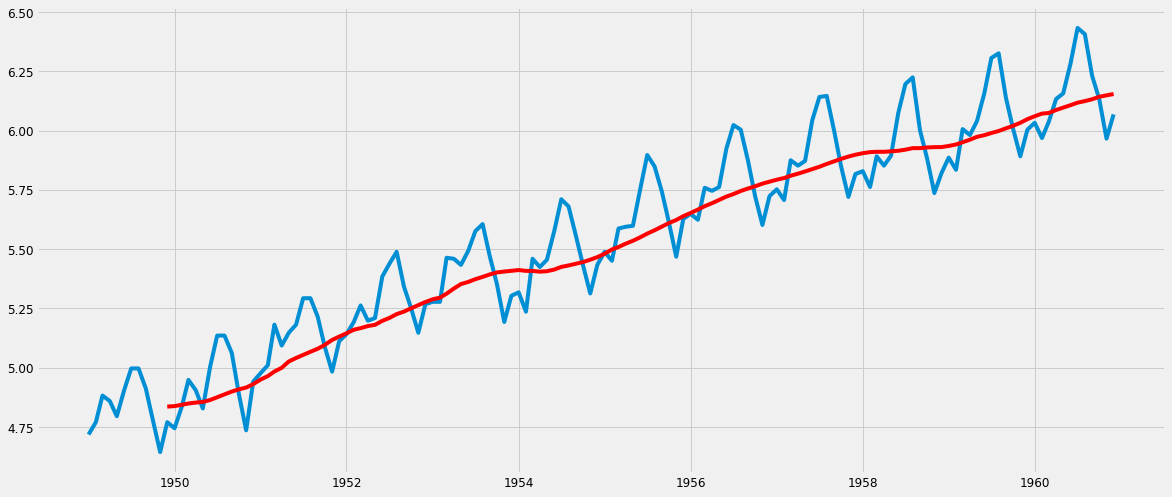

In [21]:
moving_avg = ts_log.rolling(window=12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [22]:
ts_log_moving_avg_diff = ts_log.passengers - moving_avg.passengers
ts_log_moving_avg_diff.head(12)

year
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
Name: passengers, dtype: float64

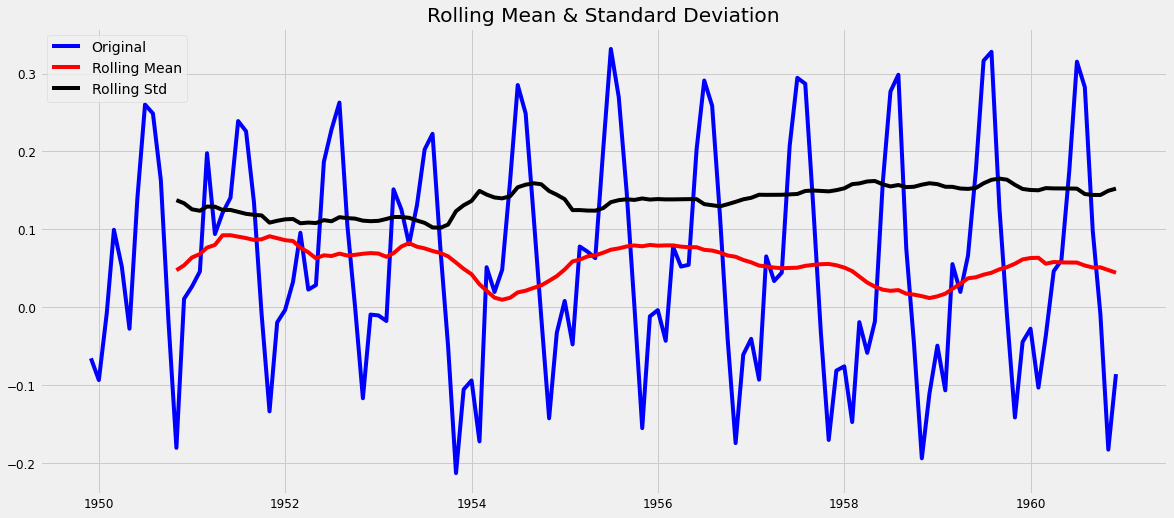

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [23]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

### Exponentially weighted moving average:
* To overcome the problem of choosing a defined window in moving average, we can use exponential weighted moving average
* We take a ‘weighted moving average’ where more recent values are given a higher weight.
* There can be many technique for assigning weights. A popular one is exponentially weighted moving average where weights are assigned to all the previous values with a decay factor.

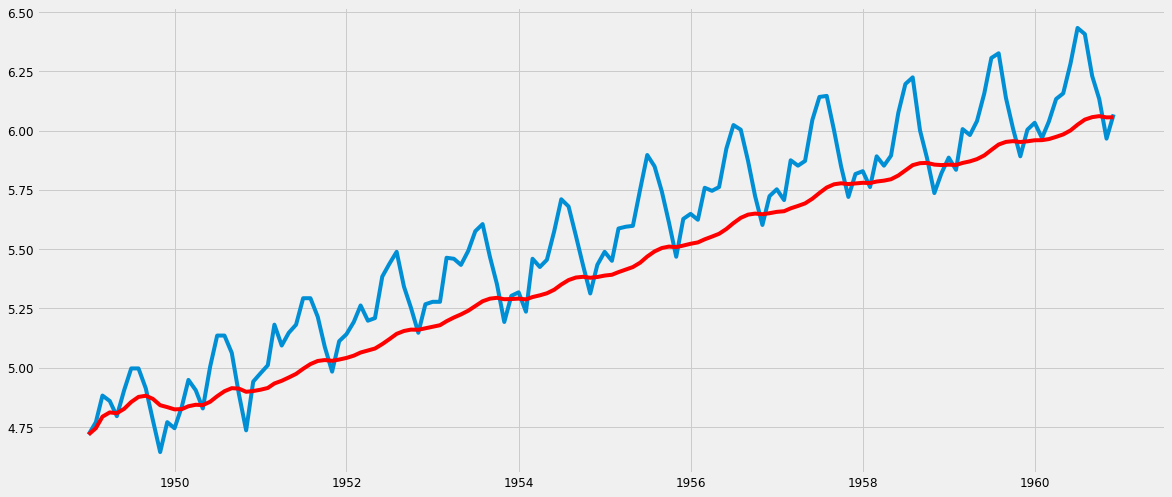

In [24]:
expwighted_avg = ts_log.ewm(halflife=12).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

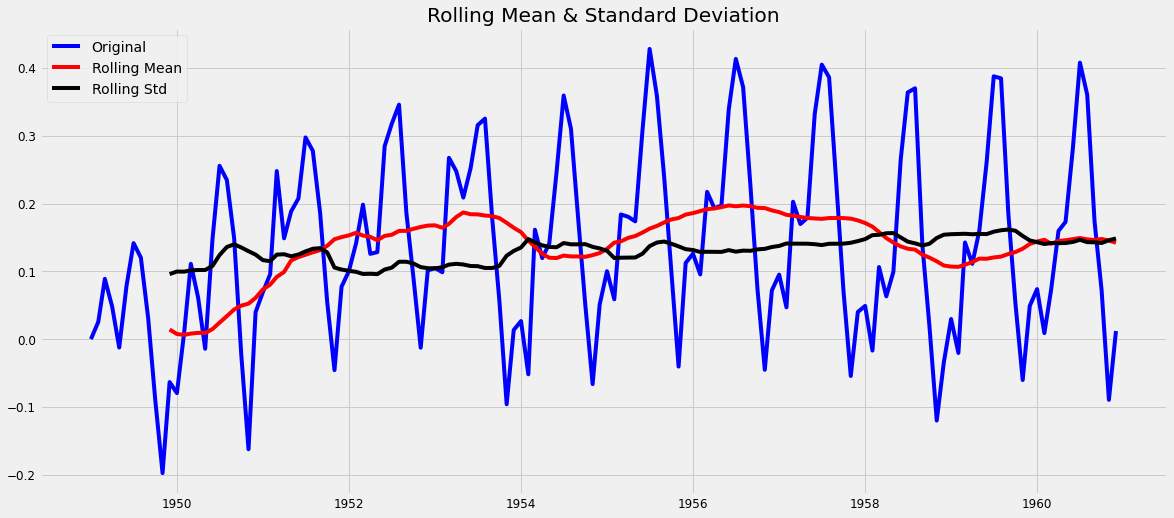

Results of Dickey-Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [25]:
ts_log_ewma_diff = ts_log.passengers - expwighted_avg.passengers
test_stationarity(ts_log_ewma_diff)

### Further Techniques to remove Seasonality and Trend¶
* The simple trend reduction techniques discussed before don’t work in all cases, particularly the ones with high seasonality.

### Differencing
* In this technique, we take the difference of the observation at a particular instant with that at the previous instant.
* First order differencing in Pandas

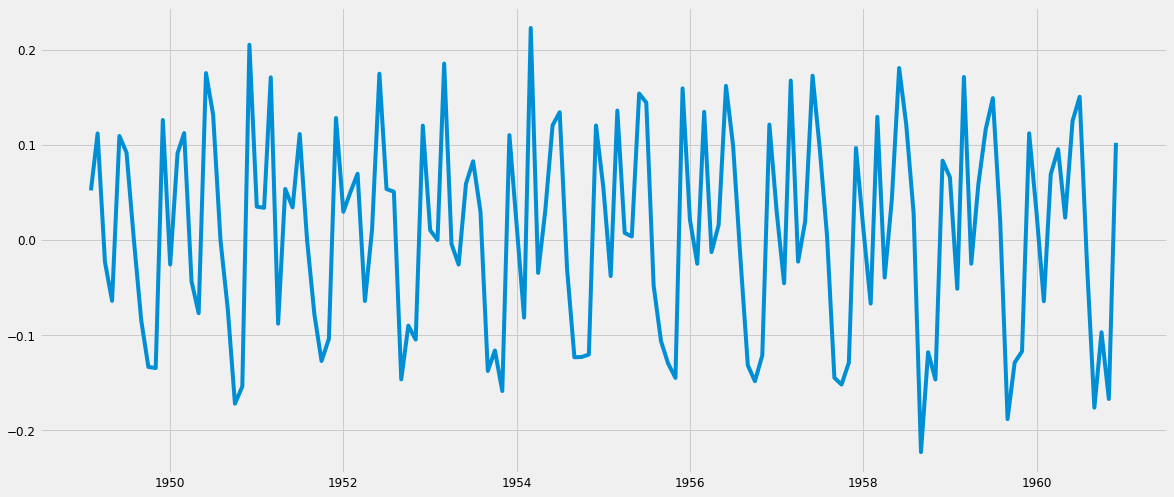

In [26]:
ts_log_diff = ts_log.passengers - ts_log.passengers.shift()
plt.plot(ts_log_diff)

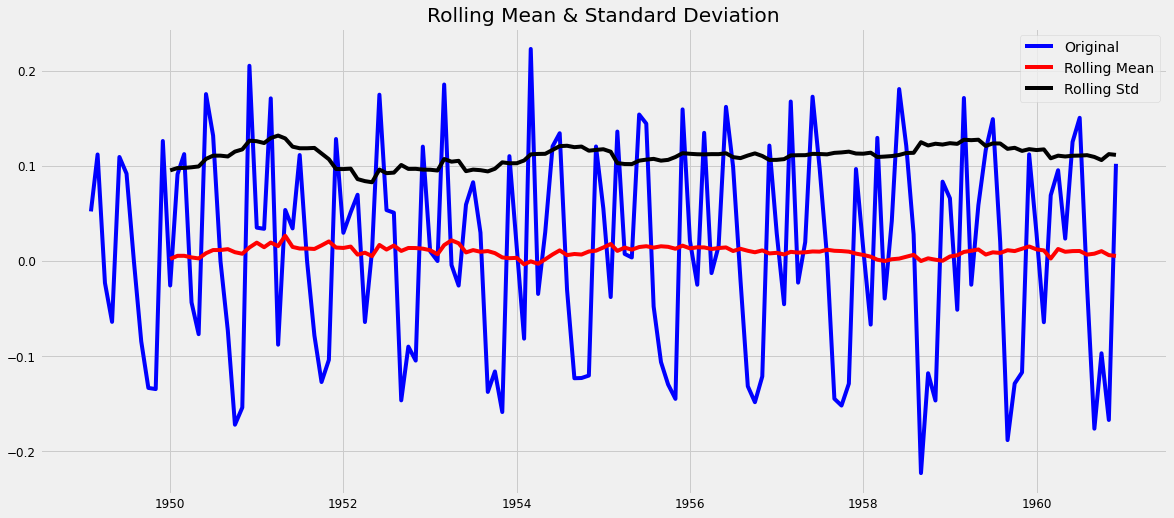

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [27]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

### Decomposition

In this approach, both trend and seasonality are modeled separately and the remaining part of the series is returned.

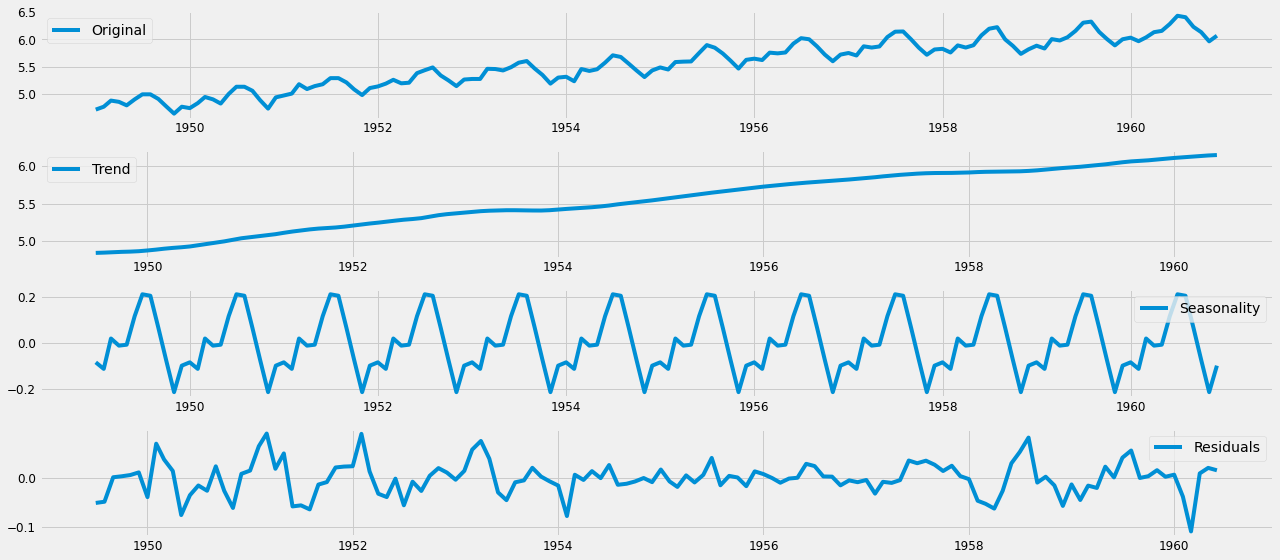

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()